In [27]:
import json
from datetime import datetime, timedelta
import pytz
from minio import Minio

# Initialize MinIO client
client = Minio("localhost:9000",
               access_key="minioadmin",
               secret_key="minioadmin",
               secure=False)

bucket_name = "warehouse"

# Get current time in UTC and calculate time one hour ago
current_time = datetime.utcnow().replace(tzinfo=pytz.UTC)
one_hour_ago = current_time - timedelta(hours=20)

# Get list of all objects in the bucket
all_objects = list(client.list_objects(bucket_name, recursive=True))
latest_objects = [obj for obj in all_objects if obj.last_modified > one_hour_ago]
print(f"Found {len(all_objects)} objects.")



def parse_minio_data(data):
    """Parse MinIO JSON string logs into structured format."""
    records = []
    for line in data.strip().split("\n"):
        try:
            record = json.loads(line.strip("'"))  # Convert string to JSON
            record["timestamp"] = datetime.strptime(record["timestamp"], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
            records.append(record)
        except json.JSONDecodeError as e:
            print(f"Skipping invalid line: {line} due to error: {e}")
    return records


Found 20471 objects.


In [28]:
# Retrieve and parse data
parsed_data = []
for obj in all_objects:
    try:
        response = client.get_object(bucket_name, obj.object_name)
        data = response.read().decode('utf-8')
    except Exception as e:
        print(f"Error retrieving object {obj.object_name}: {e}")
        continue
    finally:
        response.close()
        response.release_conn()

    parsed_data.extend(parse_minio_data(data))


print(f"Parsed {len(parsed_data)} records.")

Parsed 17083314 records.


In [29]:
parsed_data

[{'name': 'node_cpu_guest_seconds_total',
  'value': '0',
  'labels': {'mode': 'nice',
   'instance': '10.71.0.59:9102',
   '__name__': 'node_cpu_guest_seconds_total',
   'os_type': 'linux',
   'vm': 'Ubuntu',
   'cpu': '0',
   'job': 'node'},
  'timestamp': datetime.datetime(2025, 4, 11, 14, 2, 34, tzinfo=<UTC>)},
 {'name': 'node_cpu_guest_seconds_total',
  'value': '0',
  'labels': {'mode': 'user',
   'instance': '10.71.0.59:9102',
   '__name__': 'node_cpu_guest_seconds_total',
   'os_type': 'linux',
   'vm': 'Ubuntu',
   'cpu': '0',
   'job': 'node'},
  'timestamp': datetime.datetime(2025, 4, 11, 14, 2, 34, tzinfo=<UTC>)},
 {'name': 'node_cpu_guest_seconds_total',
  'value': '0',
  'labels': {'mode': 'nice',
   'instance': '10.71.0.59:9102',
   '__name__': 'node_cpu_guest_seconds_total',
   'os_type': 'linux',
   'vm': 'Ubuntu',
   'cpu': '1',
   'job': 'node'},
  'timestamp': datetime.datetime(2025, 4, 11, 14, 2, 34, tzinfo=<UTC>)},
 {'name': 'node_cpu_guest_seconds_total',
  'valu

In [30]:
len(parsed_data)

17083314

In [31]:
metrics = list()
for obj in parsed_data:
    if obj["name"] in metrics:
        continue
    else:
        metrics.append(obj["name"])
metrics

['node_cpu_guest_seconds_total',
 'node_cpu_online',
 'node_cpu_seconds_total',
 'node_disk_discard_time_seconds_total',
 'node_disk_discarded_sectors_total',
 'node_disk_discards_completed_total',
 'node_disk_discards_merged_total',
 'node_disk_filesystem_info',
 'node_disk_flush_requests_time_seconds_total',
 'node_disk_flush_requests_total',
 'node_disk_info',
 'node_disk_io_now',
 'node_disk_io_time_seconds_total',
 'node_disk_io_time_weighted_seconds_total',
 'node_disk_read_bytes_total',
 'node_disk_read_time_seconds_total',
 'node_disk_reads_completed_total',
 'node_disk_reads_merged_total',
 'node_disk_write_time_seconds_total',
 'node_disk_writes_completed_total',
 'node_disk_writes_merged_total',
 'node_disk_written_bytes_total',
 'node_memory_Active_anon_bytes',
 'node_memory_Active_bytes',
 'node_memory_Active_file_bytes',
 'node_memory_AnonHugePages_bytes',
 'node_memory_AnonPages_bytes',
 'node_memory_Bounce_bytes',
 'node_memory_Buffers_bytes',
 'node_memory_Cached_bytes

In [32]:
critical_metrics = [
    "node_cpu_seconds_total",
    "node_cpu_guest_seconds_total",
    "node_cpu_online",
    "node_disk_io_time_seconds_total",
    "node_disk_read_bytes_total",
    "node_disk_written_bytes_total",
    "node_pressure_cpu_waiting_seconds_total",
    "node_pressure_memory_waiting_seconds_total",
    "node_memory_MemAvailable_bytes",
    "node_memory_MemFree_bytes",
    "node_memory_MemTotal_bytes",
    "node_memory_SwapFree_bytes",
    "node_memory_SwapTotal_bytes",
    "node_memory_Cached_bytes",
    "node_memory_Active_anon_bytes",
    "node_systemd_unit_state"
]

In [33]:
critical_parsed_data = []
for obj in parsed_data:
    if obj["name"] in critical_metrics:
        critical_parsed_data.append(obj)
    else:
        continue

In [34]:
critical_metrics_parsed = list()
for obj in critical_parsed_data:
    if obj["name"] in critical_metrics_parsed:
        continue
    else:
        critical_metrics_parsed.append(obj["name"])
critical_metrics_parsed

['node_cpu_guest_seconds_total',
 'node_cpu_online',
 'node_cpu_seconds_total',
 'node_disk_io_time_seconds_total',
 'node_disk_read_bytes_total',
 'node_disk_written_bytes_total',
 'node_memory_Active_anon_bytes',
 'node_memory_Cached_bytes',
 'node_memory_MemAvailable_bytes',
 'node_memory_MemFree_bytes',
 'node_memory_MemTotal_bytes',
 'node_memory_SwapFree_bytes',
 'node_memory_SwapTotal_bytes',
 'node_pressure_cpu_waiting_seconds_total',
 'node_pressure_memory_waiting_seconds_total',
 'node_systemd_unit_state']

In [35]:
metrics_data = []
for metric in critical_parsed_data:
    vm_name = metric['labels'].get('vm')
    metrics_data.append({
    'vm': vm_name,
    'metric': metric['name'],
    'value': float(metric['value']),
    'state': metric['labels'].get('state', None),
    'service': metric['labels'].get('name', None),
    'timestamp': metric['timestamp']
})



In [36]:
len(metrics_data)

14107704

In [37]:
metrics_data_valid = list()
for obj in metrics_data:
    if obj["vm"] in ['Lubuntu','Lubuntu V2', 'Ubuntu']:
        metrics_data_valid.append(obj)
    else:
        continue

In [38]:
len(metrics_data_valid)

14048020

In [39]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_data)

In [40]:
metrics_df

,vm,metric,value,state,service,timestamp
0,Ubuntu,node_cpu_guest_seconds_total,0.0,None,None,2025-04-11 14:02:34+00:00
1,Ubuntu,node_cpu_guest_seconds_total,0.0,None,None,2025-04-11 14:02:34+00:00
2,Ubuntu,node_cpu_guest_seconds_total,0.0,None,None,2025-04-11 14:02:34+00:00
3,Ubuntu,node_cpu_guest_seconds_total,0.0,None,None,2025-04-11 14:02:34+00:00
4,Ubuntu,node_cpu_guest_seconds_total,0.0,None,None,2025-04-11 14:02:34+00:00
...,...,...,...,...,...,...
14107699,Ubuntu,node_systemd_unit_state,NaN,activating,blockdev@dev-loop3.target,2025-04-15 16:33:49+00:00
14107700,Ubuntu,node_systemd_unit_state,NaN,deactivating,cryptsetup-pre.target,2025-04-15 16:33:49+00:00
14107701,Ubuntu,node_systemd_unit_state,NaN,active,multipathd.service,2025-04-15 16:33:49+00:00
14107702,Ubuntu,node_systemd_unit_state,NaN,deactivating,dpkg-db-backup.service,2025-04-15 16:33:49+00:00


In [41]:
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pytz

############################
# 1. Processing Functions  #
############################

def process_system_metrics(group):
    """Extract various system metrics from the grouped DataFrame."""
    metrics = {}
    # CPU metrics
    metrics['node_cpu_seconds_total'] = group[group['metric'] == 'node_cpu_seconds_total']['value'].astype(float).mean() if not group[group['metric'] == 'node_cpu_seconds_total'].empty else 0
    metrics['node_cpu_guest_seconds_total'] = group[group['metric'] == 'node_cpu_guest_seconds_total']['value'].astype(float).mean() if not group[group['metric'] == 'node_cpu_guest_seconds_total'].empty else 0
    metrics['node_cpu_online'] = group[group['metric'] == 'node_cpu_online']['value'].astype(float).mean() if not group[group['metric'] == 'node_cpu_online'].empty else 0

    # Disk metrics
    metrics['node_disk_io_time_seconds_total'] = group[group['metric'] == 'node_disk_io_time_seconds_total']['value'].astype(float).sum() if not group[group['metric'] == 'node_disk_io_time_seconds_total'].empty else 0
    metrics['node_disk_read_bytes_total'] = group[group['metric'] == 'node_disk_read_bytes_total']['value'].astype(float).sum() if not group[group['metric'] == 'node_disk_read_bytes_total'].empty else 0
    metrics['node_disk_written_bytes_total'] = group[group['metric'] == 'node_disk_written_bytes_total']['value'].astype(float).sum() if not group[group['metric'] == 'node_disk_written_bytes_total'].empty else 0

    # Pressure metrics
    metrics['node_pressure_cpu_waiting_seconds_total'] = group[group['metric'] == 'node_pressure_cpu_waiting_seconds_total']['value'].astype(float).mean() if not group[group['metric'] == 'node_pressure_cpu_waiting_seconds_total'].empty else 0
    metrics['node_pressure_memory_waiting_seconds_total'] = group[group['metric'] == 'node_pressure_memory_waiting_seconds_total']['value'].astype(float).mean() if not group[group['metric'] == 'node_pressure_memory_waiting_seconds_total'].empty else 0

    # Memory metrics
    metrics['node_memory_MemAvailable_bytes'] = group[group['metric'] == 'node_memory_MemAvailable_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_MemAvailable_bytes'].empty else 0
    metrics['node_memory_MemFree_bytes'] = group[group['metric'] == 'node_memory_MemFree_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_MemFree_bytes'].empty else 0
    metrics['node_memory_MemTotal_bytes'] = group[group['metric'] == 'node_memory_MemTotal_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_MemTotal_bytes'].empty else 0
    metrics['node_memory_SwapFree_bytes'] = group[group['metric'] == 'node_memory_SwapFree_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_SwapFree_bytes'].empty else 0
    metrics['node_memory_SwapTotal_bytes'] = group[group['metric'] == 'node_memory_SwapTotal_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_SwapTotal_bytes'].empty else 0
    metrics['node_memory_Cached_bytes'] = group[group['metric'] == 'node_memory_Cached_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_Cached_bytes'].empty else 0
    metrics['node_memory_Active_anon_bytes'] = group[group['metric'] == 'node_memory_Active_anon_bytes']['value'].astype(float).mean() if not group[group['metric'] == 'node_memory_Active_anon_bytes'].empty else 0

    return metrics

def process_service_states(group):
    """Extract and aggregate service state metrics from the grouped DataFrame."""
    CRITICAL_SERVICES = {
        "sshd.service", "systemd-journald.service", "systemd-logind.service", "NetworkManager.service", "nginx.service"
    }
    services = group[group['metric'] == 'node_systemd_unit_state']
    failed = services[services['state'] == 'failed']
    critical_failed = failed[failed['service'].isin(CRITICAL_SERVICES)]
    service_states = {
        'active_count': int(services[services['state'] == 'active']['value'].astype(float).sum()) if not services.empty else 0,
        'failed_count': len(critical_failed['service'].unique()) if not critical_failed.empty else 0,
        'failed_services': critical_failed['service'].unique().tolist() if not critical_failed.empty else []
    }
    if len(service_states['failed_services']) > 3:
        service_states['failed_services'] = service_states['failed_services'][:5] + ['...']
    return service_states

def generate_vm_snapshot(timestamp, vm, group):
    """Generate a snapshot (dictionary) for one VM at a given timestamp."""
    sys_metrics = process_system_metrics(group)
    serv_states = process_service_states(group)
    snapshot = {
        'timestamp': timestamp,
        'vm': vm,
        'instance': group['labels.instance'].iloc[0] if 'labels.instance' in group.columns else vm,
        'system_metrics': sys_metrics,
        'service_states': serv_states,
        'anomalies': [],
        'suggested_actions': []
    }
    if sys_metrics.get('node_memory_MemTotal_bytes', 0) > 0:
        mem_pct_used = (1 - sys_metrics['node_memory_MemAvailable_bytes'] / sys_metrics['node_memory_MemTotal_bytes']) * 100
    else:
        mem_pct_used = 0
    if mem_pct_used > 90:
        snapshot['anomalies'].append('HIGH_MEMORY_USAGE')
        snapshot['suggested_actions'].append('CHECK_MEMORY')
    if serv_states.get('failed_count', 0) > 0:
        snapshot['anomalies'].append('FAILED_SERVICES')
        snapshot['suggested_actions'].append('RESTART_SERVICES')
    return snapshot

def format_llm_prompt(snapshot):
    """Create a human-friendly prompt for a single VM."""
    vm = snapshot['vm']
    ts = snapshot['timestamp']
    inst = snapshot.get('instance', vm)
    sm = snapshot['system_metrics']
    ss = snapshot['service_states']
    if sm.get('node_memory_MemTotal_bytes', 0) > 0:
        mem_pct_used = (1 - sm.get('node_memory_MemAvailable_bytes', 0) / sm.get('node_memory_MemTotal_bytes', 1)) * 100
        mem_total_gb = sm.get('node_memory_MemTotal_bytes', 0) / 1e9
        mem_available_gb = sm.get('node_memory_MemAvailable_bytes', 0) / 1e9
    else:
        mem_pct_used, mem_total_gb, mem_available_gb = 0, 0, 0

    prompt = f"System Monitoring Report for VM {vm} (Instance: {inst}) at {ts}:\n"
    prompt += f"- CPU Idle: {sm.get('node_cpu_seconds_total', 0):.1f} seconds\n"
    prompt += f"- Memory used: {mem_pct_used:.1f}% of {mem_total_gb:.1f}GB total (Available: {mem_available_gb:.1f}GB)\n"
    prompt += f"- Disk I/O time: {sm.get('node_disk_io_time_seconds_total', 0):.1f} seconds\n"
    prompt += f"- Failed services: {ss.get('failed_services', [])} (Count: {ss.get('failed_count', 0)})\n"
    if snapshot['anomalies']:
        prompt += f"Detected anomalies: {', '.join(snapshot['anomalies'])}\n"
    prompt += "\nBased on the above data, what action should be taken for this VM? Options: NO_ACTION, RESTART_SERVICES, RESTART_VM, MIGRATE_VM, SCALE_UP. Explain your reasoning."
    return prompt

def format_multi_vm_prompt_with_details(snapshots, model, scaler, threshold):
    """Create a cluster-level instruction prompt, appending anomaly details for each VM."""
    if not snapshots:
        return ""
    ts = snapshots[0]['timestamp']
    prompt = f"System Monitoring Report at {ts} across VMs:\n\n"
    for snap in snapshots:
        vm = snap['vm']
        inst = snap.get('instance', vm)
        sm = snap['system_metrics']
        ss = snap['service_states']
        if sm.get('node_memory_MemTotal_bytes', 0) > 0:
            mem_pct_used = (1 - sm.get('node_memory_MemAvailable_bytes', 0) / sm.get('node_memory_MemTotal_bytes', 1)) * 100
            mem_total_gb = sm.get('node_memory_MemTotal_bytes', 0) / 1e9
            mem_available_gb = sm.get('node_memory_MemAvailable_bytes', 0) / 1e9
        else:
            mem_pct_used, mem_total_gb, mem_available_gb = 0, 0, 0

        vm_prompt = f"VM {vm} (Instance: {inst}):\n"
        vm_prompt += f"  - CPU Idle: {sm.get('node_cpu_seconds_total', 0):.1f} seconds\n"
        vm_prompt += f"  - Memory used: {mem_pct_used:.1f}% of {mem_total_gb:.1f}GB total (Available: {mem_available_gb:.1f}GB)\n"
        vm_prompt += f"  - Disk I/O time: {sm.get('node_disk_io_time_seconds_total', 0):.1f} seconds\n"
        vm_prompt += f"  - Failed services: {ss.get('failed_services', [])} (Count: {ss.get('failed_count', 0)})\n"
        if snap['anomalies']:
            vm_prompt += f"  Detected anomalies: {', '.join(snap['anomalies'])}\n"
        # Append anomaly details computed by the smart label function.
        record = generate_smart_instruction_label(snap, model, scaler, threshold)
        if record["anomaly_details"]:
            details_text = "; ".join(record["anomaly_details"])
            vm_prompt += f"  Anomaly Details: {details_text}\n"
        vm_prompt += "\n"
        prompt += vm_prompt
    prompt += ("Based on the above data, compare the statuses of the VMs and decide the appropriate action for each. "
               "Options: NO_ACTION, RESTART_SERVICES, RESTART_VM, MIGRATE_VM, SCALE_UP. Explain your reasoning for each VM.")
    return prompt

def generate_prompts_from_df(df, window_minutes=5):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    snapshots, per_vm_prompts, multi_vm_prompts = [], [], {}

    grouped = df.groupby([pd.Grouper(key='timestamp', freq=f'{window_minutes}Min'), 'vm'])
    for (timestamp, vm), group in grouped:
        snap = generate_vm_snapshot(timestamp, vm, group)
        snapshots.append(snap)
        per_vm_prompts.append(format_llm_prompt(snap))
        window_key = timestamp.strftime('%Y-%m-%d %H:%M:%S')
        multi_vm_prompts.setdefault(window_key, []).append(snap)

    # Combine snapshots in each time window using enhanced prompt
    multi_vm_prompt_list = []
    for window_key, snap_list in multi_vm_prompts.items():
        # The model, scaler, and threshold are added later
        multi_vm_prompt_list.append((window_key, snap_list))

    return snapshots, per_vm_prompts, multi_vm_prompt_list

snapshots, per_vm_prompts, multi_vm_prompts = generate_prompts_from_df(metrics_df, window_minutes=2)

In [42]:
len(snapshots)

1153

In [24]:

snapshots

[{'timestamp': Timestamp('2025-04-15 15:14:00+0000', tz='UTC'),
  'vm': 'Lubuntu',
  'instance': 'Lubuntu',
  'system_metrics': {'node_cpu_seconds_total': np.float64(532.9316666666667),
   'node_cpu_guest_seconds_total': np.float64(0.0),
   'node_cpu_online': 0,
   'node_disk_io_time_seconds_total': np.float64(4.771),
   'node_disk_read_bytes_total': np.float64(698225664.0),
   'node_disk_written_bytes_total': np.float64(43660288.0),
   'node_pressure_cpu_waiting_seconds_total': np.float64(57.478671000000006),
   'node_pressure_memory_waiting_seconds_total': np.float64(0.000412),
   'node_memory_MemAvailable_bytes': np.float64(2895237120.0),
   'node_memory_MemFree_bytes': np.float64(2308747264.0),
   'node_memory_MemTotal_bytes': np.float64(3668586496.0),
   'node_memory_SwapFree_bytes': np.float64(2125459456.0),
   'node_memory_SwapTotal_bytes': np.float64(2125459456.0),
   'node_memory_Cached_bytes': np.float64(640811008.0),
   'node_memory_Active_anon_bytes': np.float64(412528640.0

In [25]:
multi_vm_prompts

[('2025-04-15 15:14:00',
  [{'timestamp': Timestamp('2025-04-15 15:14:00+0000', tz='UTC'),
    'vm': 'Lubuntu',
    'instance': 'Lubuntu',
    'system_metrics': {'node_cpu_seconds_total': np.float64(532.9316666666667),
     'node_cpu_guest_seconds_total': np.float64(0.0),
     'node_cpu_online': 0,
     'node_disk_io_time_seconds_total': np.float64(4.771),
     'node_disk_read_bytes_total': np.float64(698225664.0),
     'node_disk_written_bytes_total': np.float64(43660288.0),
     'node_pressure_cpu_waiting_seconds_total': np.float64(57.478671000000006),
     'node_pressure_memory_waiting_seconds_total': np.float64(0.000412),
     'node_memory_MemAvailable_bytes': np.float64(2895237120.0),
     'node_memory_MemFree_bytes': np.float64(2308747264.0),
     'node_memory_MemTotal_bytes': np.float64(3668586496.0),
     'node_memory_SwapFree_bytes': np.float64(2125459456.0),
     'node_memory_SwapTotal_bytes': np.float64(2125459456.0),
     'node_memory_Cached_bytes': np.float64(640811008.0),

In [43]:
# 4. Feature Extraction      #
###############################

def extract_features(snapshot):
    """Extract features from 15 critical metrics."""
    sm = snapshot['system_metrics']
    features = np.array([
        float(sm.get('node_cpu_seconds_total', 0)),
        float(sm.get('node_cpu_guest_seconds_total', 0)),
        float(sm.get('node_cpu_online', 0)),
        float(sm.get('node_disk_io_time_seconds_total', 0)),
        float(sm.get('node_disk_read_bytes_total', 0)),
        float(sm.get('node_disk_written_bytes_total', 0)),
        float(sm.get('node_pressure_cpu_waiting_seconds_total', 0)),
        float(sm.get('node_pressure_memory_waiting_seconds_total', 0)),
        float(sm.get('node_memory_MemAvailable_bytes', 0)),
        float(sm.get('node_memory_MemFree_bytes', 0)),
        float(sm.get('node_memory_MemTotal_bytes', 0)),
        float(sm.get('node_memory_SwapFree_bytes', 0)),
        float(sm.get('node_memory_SwapTotal_bytes', 0)),
        float(sm.get('node_memory_Cached_bytes', 0)),
        float(sm.get('node_memory_Active_anon_bytes', 0))
    ])
    return features

FEATURE_NAMES = [
    "CPU Idle Seconds", "CPU Guest Seconds", "CPU Online", "Disk I/O Time Seconds",
    "Disk Read Bytes", "Disk Written Bytes", "Pressure CPU Waiting Seconds",
    "Pressure Memory Waiting Seconds", "Memory Available (bytes)", "Memory Free (bytes)",
    "Memory Total (bytes)", "Swap Free (bytes)", "Swap Total (bytes)",
    "Memory Cached (bytes)", "Active Anon Memory (bytes)"
]

###################################
# 5. Normalization and Dataset    #
###################################

# Assume snapshots are generated from a DataFrame 'df'
# snapshots, per_vm_prompts, multi_vm_prompt_list = generate_prompts_from_df(df, window_minutes=2)
# For illustration, assume 'snapshots' is available.

features_list = [extract_features(snap) for snap in snapshots]
features_array = np.vstack(features_list)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assume features_normalized is already defined
features_tensor = torch.tensor(features_normalized, dtype=torch.float32)
dataset = TensorDataset(features_tensor)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [46]:
for e in data_loader:
    print(e)


[tensor([[ 1.3268,  0.0000,  1.3694,  0.2207,  0.0079, -0.2009,  2.3614, -0.2630,
          1.3109,  1.2892,  1.3694, -1.3548, -1.3694,  0.4049,  0.7793],
        [ 0.2090,  0.0000, -0.7302, -0.4269, -0.3486, -0.3348, -0.0175, -0.2632,
         -0.6500, -0.6145, -0.7302,  0.7672,  0.7302, -0.3122, -0.4611]])]
[tensor([[-0.3671,  0.0000, -0.7302,  1.8830,  1.7526,  1.0506, -0.2782, -0.2630,
         -0.6839, -1.6742, -0.7302,  0.7672,  0.7302,  2.6264, -0.4624],
        [ 0.7073,  0.0000,  1.3694,  0.2284, -0.0034, -0.2608, -0.4864, -0.2630,
          1.5143,  1.5270,  1.3694, -1.3548, -1.3694,  0.3337,  0.3948]])]
[tensor([[-1.0875,  0.0000, -0.7302, -0.8718, -0.4289, -0.3637, -0.7097, -0.2631,
         -0.6368, -0.5562, -0.7302,  0.7672,  0.7302, -0.4183, -0.4873],
        [-0.8684,  0.0000, -0.7302, -0.7079, -0.3996, -0.3565, -0.6158, -0.2631,
         -0.6327, -0.5688, -0.7302,  0.7672,  0.7302, -0.3757, -0.4788]])]
[tensor([[-0.5410,  0.0000, -0.7302, -0.3284,  0.1123, -0.0990, -0.

In [48]:


class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8, dropout_rate=0.2):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Use a smaller model since data is limited
input_dim = features_tensor.shape[1]
model = SparseAutoencoder(input_dim=input_dim, latent_dim=15, dropout_rate=0.2)

def train_autoencoder(model, data_loader, num_epochs=300, lr=1e-3, weight_decay=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in data_loader:
            optimizer.zero_grad()
            batch_features = batch[0]
            loss = criterion(model(batch_features), batch_features)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(data_loader):.4f}")

train_autoencoder(model, data_loader)


Epoch 1: Loss = 0.5526
Epoch 2: Loss = 0.3205
Epoch 3: Loss = 0.2856
Epoch 4: Loss = 0.2689
Epoch 5: Loss = 0.2538
Epoch 6: Loss = 0.2311
Epoch 7: Loss = 0.2108
Epoch 8: Loss = 0.2016
Epoch 9: Loss = 0.2246
Epoch 10: Loss = 0.2051
Epoch 11: Loss = 0.2111
Epoch 12: Loss = 0.1875
Epoch 13: Loss = 0.1787
Epoch 14: Loss = 0.1837
Epoch 15: Loss = 0.1935
Epoch 16: Loss = 0.1881
Epoch 17: Loss = 0.1876
Epoch 18: Loss = 0.1835
Epoch 19: Loss = 0.1755
Epoch 20: Loss = 0.1790
Epoch 21: Loss = 0.1806
Epoch 22: Loss = 0.1650
Epoch 23: Loss = 0.1576
Epoch 24: Loss = 0.1821
Epoch 25: Loss = 0.1711
Epoch 26: Loss = 0.1984
Epoch 27: Loss = 0.1798
Epoch 28: Loss = 0.1716
Epoch 29: Loss = 0.1671
Epoch 30: Loss = 0.1852
Epoch 31: Loss = 0.1758
Epoch 32: Loss = 0.1789
Epoch 33: Loss = 0.1704
Epoch 34: Loss = 0.1733
Epoch 35: Loss = 0.1615
Epoch 36: Loss = 0.1663
Epoch 37: Loss = 0.1469
Epoch 38: Loss = 0.1696
Epoch 39: Loss = 0.1703
Epoch 40: Loss = 0.1617
Epoch 41: Loss = 0.1755
Epoch 42: Loss = 0.1676
E

In [49]:
############################################
# 7. Reconstruction Error and Anomaly Info   #
############################################

import torch.nn.functional as F

def compute_reconstruction_error(model, feature_vector):
    model.eval()
    with torch.no_grad():
        reconstructed = model(feature_vector)
        return F.mse_loss(reconstructed, feature_vector, reduction='mean').item()

def compute_reconstruction_error_vector(model, feature_vector):
    model.eval()
    with torch.no_grad():
        reconstructed = model(feature_vector)
        return torch.abs(reconstructed - feature_vector).squeeze(0)

def get_anomaly_details(error_vector, raw_features, threshold_ratio=0.3, absolute_threshold=0.2):
    errors_np = error_vector.cpu().numpy()
    sorted_errors = np.sort(errors_np)[::-1]
    index_cutoff = max(1, int(len(errors_np) * threshold_ratio))
    dynamic_threshold = sorted_errors[index_cutoff - 1]
    details = []
    for i, error in enumerate(errors_np):
        if error >= max(dynamic_threshold, absolute_threshold):
            details.append(f"{FEATURE_NAMES[i]} (raw: {raw_features[i]:.2f}, error: {error:.3f})")
    return details

def smart_generate_label(reconstruction_error, threshold):
    return "ANOMALY_DETECTED" if reconstruction_error > threshold else "NO_ACTION"

def generate_smart_instruction_label(snapshot, model, scaler, threshold):
    raw_features = extract_features(snapshot)
    features_norm = scaler.transform(raw_features.reshape(1, -1))
    feature_tensor = torch.tensor(features_norm, dtype=torch.float32)
    reconstruction_error = compute_reconstruction_error(model, feature_tensor)
    error_vector = compute_reconstruction_error_vector(model, feature_tensor)
    anomaly_details = get_anomaly_details(error_vector, raw_features) if reconstruction_error > threshold else []
    label = smart_generate_label(reconstruction_error, threshold)
    instruction = format_llm_prompt(snapshot)
    return {
        "instruction": instruction,
        "label": label,
        "anomaly_score": reconstruction_error,
        "anomaly_details": anomaly_details
    }

# Compute threshold from training errors.
errors = [compute_reconstruction_error(model, features_tensor[i].unsqueeze(0)) for i in range(features_tensor.size(0))]
errors = np.array(errors)
threshold = errors.mean() + 3 * errors.std()
print("Autoencoder error threshold:", threshold)

Autoencoder error threshold: 0.47580434949380784


In [50]:
###########################################
# 8. Cluster-Level Instruction Generation #
###########################################

def group_snapshots_by_window(snapshots, window_minutes=2):
    window_dict = {}
    for snap in snapshots:
        key = snap['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
        window_dict.setdefault(key, []).append(snap)
    return window_dict

def generate_cluster_instruction_label(snapshots, model, scaler, threshold, window_minutes=2):
    window_dict = group_snapshots_by_window(snapshots, window_minutes)
    cluster_dataset = []
    for window_key, snap_list in window_dict.items():
        # Use enhanced prompt with details.
        cluster_instruction = format_multi_vm_prompt_with_details(snap_list, model, scaler, threshold)
        vm_actions = {}
        vm_details = {}
        for snap in snap_list:
            record = generate_smart_instruction_label(snap, model, scaler, threshold)
            vm_actions[snap['vm']] = record['label']
            vm_details[snap['vm']] = {
                "anomaly_score": record["anomaly_score"],
                "anomaly_details": record["anomaly_details"]
            }
        label_data = {"actions": vm_actions, "details": vm_details}
        cluster_dataset.append({
            "instruction": cluster_instruction,
            "label": json.dumps(label_data)
        })
    return cluster_dataset

cluster_dataset = generate_cluster_instruction_label(snapshots, model, scaler, threshold, window_minutes=2)


In [51]:
len(cluster_dataset)

406

In [52]:
cluster_dataset

[{'instruction': "System Monitoring Report at 2025-04-10 16:00:00+00:00 across VMs:\n\nVM Lubuntu (Instance: Lubuntu):\n  - CPU Idle: 45.3 seconds\n  - Memory used: 19.6% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 22.6 seconds\n  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Lubuntu V2 (Instance: Lubuntu V2):\n  - CPU Idle: 45.7 seconds\n  - Memory used: 19.4% of 3.7GB total (Available: 3.0GB)\n  - Disk I/O time: 18.4 seconds\n  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Ubuntu (Instance: Ubuntu):\n  - CPU Idle: 192.7 seconds\n  - Memory used: 23.9% of 6.7GB total (Available: 5.1GB)\n  - Disk I/O time: 30.6 seconds\n  - Failed services: ['systemd-journald.service', 'systemd-logind.service', 'NetworkManager.service', 'nginx.service', '...'] (Count: 4)\n  De

In [53]:
print(cluster_dataset[0])

{'instruction': "System Monitoring Report at 2025-04-10 16:00:00+00:00 across VMs:\n\nVM Lubuntu (Instance: Lubuntu):\n  - CPU Idle: 45.3 seconds\n  - Memory used: 19.6% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 22.6 seconds\n  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Lubuntu V2 (Instance: Lubuntu V2):\n  - CPU Idle: 45.7 seconds\n  - Memory used: 19.4% of 3.7GB total (Available: 3.0GB)\n  - Disk I/O time: 18.4 seconds\n  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Ubuntu (Instance: Ubuntu):\n  - CPU Idle: 192.7 seconds\n  - Memory used: 23.9% of 6.7GB total (Available: 5.1GB)\n  - Disk I/O time: 30.6 seconds\n  - Failed services: ['systemd-journald.service', 'systemd-logind.service', 'NetworkManager.service', 'nginx.service', '...'] (Count: 4)\n  Det

In [54]:
cluster_dataset[1]["label"]

'{"actions": {"Lubuntu": "NO_ACTION", "Lubuntu V2": "NO_ACTION", "Ubuntu": "NO_ACTION"}, "details": {"Lubuntu": {"anomaly_score": 0.010570930317044258, "anomaly_details": []}, "Lubuntu V2": {"anomaly_score": 0.010665184818208218, "anomaly_details": []}, "Ubuntu": {"anomaly_score": 0.00669890595600009, "anomaly_details": []}}}'

In [55]:
cluster_dataset

[{'instruction': "System Monitoring Report at 2025-04-10 16:00:00+00:00 across VMs:\n\nVM Lubuntu (Instance: Lubuntu):\n  - CPU Idle: 45.3 seconds\n  - Memory used: 19.6% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 22.6 seconds\n  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Lubuntu V2 (Instance: Lubuntu V2):\n  - CPU Idle: 45.7 seconds\n  - Memory used: 19.4% of 3.7GB total (Available: 3.0GB)\n  - Disk I/O time: 18.4 seconds\n  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Ubuntu (Instance: Ubuntu):\n  - CPU Idle: 192.7 seconds\n  - Memory used: 23.9% of 6.7GB total (Available: 5.1GB)\n  - Disk I/O time: 30.6 seconds\n  - Failed services: ['systemd-journald.service', 'systemd-logind.service', 'NetworkManager.service', 'nginx.service', '...'] (Count: 4)\n  De

In [56]:
i = 0
for label in cluster_dataset:

    print(label["label"], i)
    i+=1

{"actions": {"Lubuntu": "NO_ACTION", "Lubuntu V2": "NO_ACTION", "Ubuntu": "NO_ACTION"}, "details": {"Lubuntu": {"anomaly_score": 0.012458805926144123, "anomaly_details": []}, "Lubuntu V2": {"anomaly_score": 0.021218689158558846, "anomaly_details": []}, "Ubuntu": {"anomaly_score": 0.024143453687429428, "anomaly_details": []}}} 0
{"actions": {"Lubuntu": "NO_ACTION", "Lubuntu V2": "NO_ACTION", "Ubuntu": "NO_ACTION"}, "details": {"Lubuntu": {"anomaly_score": 0.010570930317044258, "anomaly_details": []}, "Lubuntu V2": {"anomaly_score": 0.010665184818208218, "anomaly_details": []}, "Ubuntu": {"anomaly_score": 0.00669890595600009, "anomaly_details": []}}} 1
{"actions": {"Lubuntu": "NO_ACTION", "Lubuntu V2": "NO_ACTION", "Ubuntu": "NO_ACTION"}, "details": {"Lubuntu": {"anomaly_score": 0.009766855277121067, "anomaly_details": []}, "Lubuntu V2": {"anomaly_score": 0.009897002018988132, "anomaly_details": []}, "Ubuntu": {"anomaly_score": 0.005806860979646444, "anomaly_details": []}}} 2
{"actions":

In [57]:
print(cluster_dataset[57]["instruction"])

System Monitoring Report at 2025-04-11 14:34:00+00:00 across VMs:

VM Lubuntu (Instance: Lubuntu):
  - CPU Idle: 273.1 seconds
  - Memory used: 21.1% of 3.7GB total (Available: 2.9GB)
  - Disk I/O time: 40.0 seconds
  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)
  Detected anomalies: FAILED_SERVICES

VM Lubuntu V2 (Instance: Lubuntu V2):
  - CPU Idle: 275.8 seconds
  - Memory used: 21.2% of 3.7GB total (Available: 2.9GB)
  - Disk I/O time: 46.3 seconds
  - Failed services: ['NetworkManager.service', 'systemd-journald.service', 'systemd-logind.service'] (Count: 3)
  Detected anomalies: FAILED_SERVICES

VM Ubuntu (Instance: Ubuntu):
  - CPU Idle: 279.1 seconds
  - Memory used: 23.1% of 6.7GB total (Available: 5.2GB)
  - Disk I/O time: 58.8 seconds
  - Failed services: ['NetworkManager.service', 'nginx.service', 'systemd-journald.service', 'systemd-logind.service', '...'] (Count: 4)
  Detected anomalies: FAILED_SERVICES

Ba

In [58]:
print(cluster_dataset[57]["label"])

{"actions": {"Lubuntu": "NO_ACTION", "Lubuntu V2": "NO_ACTION", "Ubuntu": "NO_ACTION"}, "details": {"Lubuntu": {"anomaly_score": 0.0026668021455407143, "anomaly_details": []}, "Lubuntu V2": {"anomaly_score": 0.006966026499867439, "anomaly_details": []}, "Ubuntu": {"anomaly_score": 0.004990677814930677, "anomaly_details": []}}}


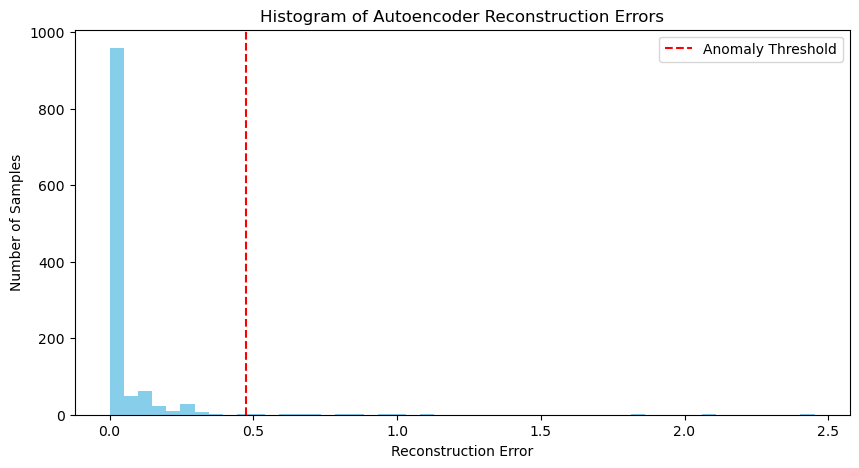

In [59]:
import matplotlib.pyplot as plt

# Compute reconstruction error for each sample in the dataset.
reconstruction_errors = []
for i in range(features_tensor.size(0)):
    error = compute_reconstruction_error(model, features_tensor[i].unsqueeze(0))
    reconstruction_errors.append(error)

# Plot histogram of reconstruction errors.
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=50, color='skyblue')
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Histogram of Autoencoder Reconstruction Errors")
plt.axvline(x=np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors), color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.show()


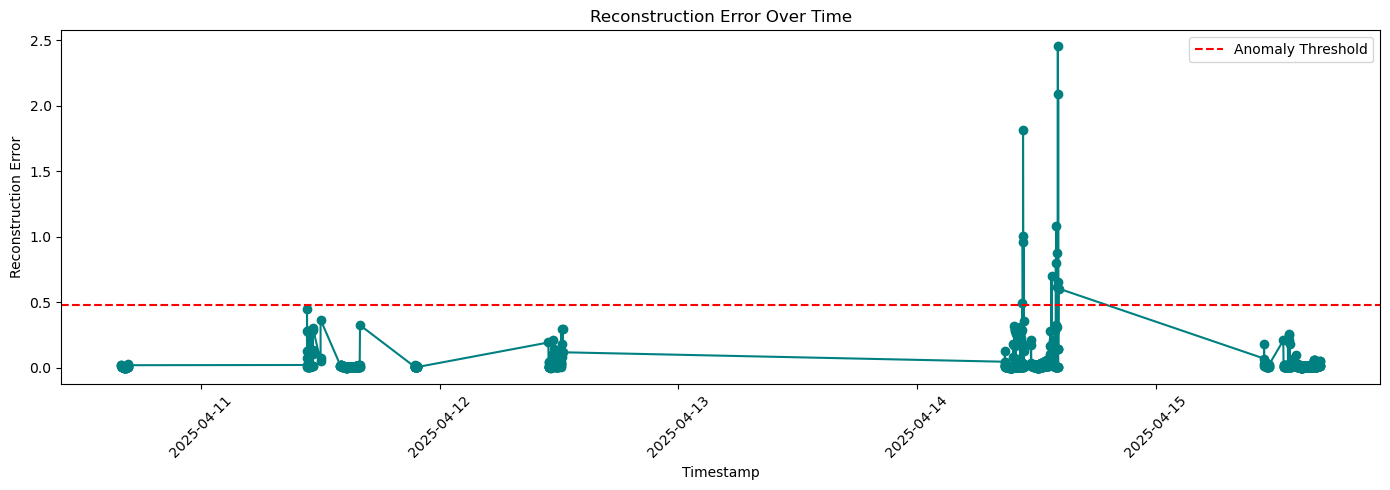

In [60]:
# Assume each sample corresponds to a timestamp from your snapshots list.
timestamps = [snap['timestamp'] for snap in snapshots]

plt.figure(figsize=(14, 5))
plt.plot(timestamps, reconstruction_errors, marker='o', linestyle='-', color='teal')
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error Over Time")
plt.axhline(y=np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors), color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model Development

In [9]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, TrainingArgs, linear_to_lora_layers
from datasets import load_dataset
from transformers import PreTrainedTokenizer, AutoTokenizer

print("Imports loaded successfully!")


Imports loaded successfully!


In [10]:
def convert_sample(sample: dict) -> dict:
    """Convert raw sample to structured training format with validation"""
    try:
        json_label = json.loads(sample['label'])
        if "actions" not in json_label or "details" not in json_label:
            raise ValueError("Invalid label structure")
        return {
            "instruction": (
                "Analyze VM status report and recommend actions:\n"
                f"{sample['instruction']}\n"
                "Options: NO_ACTION, RESTART_SERVICES, RESTART_VM, MIGRATE_VM, SCALE_UP."
            ),
            "response": sample['label']
        }
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Invalid sample: {e}")
        return None


def format_text(entry: dict) -> str:
    """Create instruction-response format with special tokens"""
    return (
        "### Instruction:\n{instruction}\n\n### Response:\n{response}"
        .format(**entry)
    )


print("Data processing functions defined.")


Data processing functions defined.


In [11]:
import json
import random
from pathlib import Path
from typing import Tuple, List

def load_vm_dataset_from_file(
    file_path: str,
    tokenizer,
    valid_frac: float = 0.1,
    test_frac: float = 0.1,
    seed: int = 42,
) -> Tuple[List[str], List[str], List[str]]:
    """
    Load your cluster_dataset_<date>.json, extract the "data" list,
    convert & format each sample, then shuffle & split into train/valid/test.
    """
    # 1) Read in the raw JSON and pull out the list under "data"
    with open(file_path, "r") as f:
        raw = json.load(f)
    records = raw.get("data", [])
    if not records:
        raise ValueError(f"No 'data' array found in {file_path}")

    # 2) Convert + format each sample, filter out any invalids
    processed = []
    for entry in records:
        conv = convert_sample(entry)
        if conv:
            processed.append(format_text(conv))

    if len(processed) == 0:
        raise ValueError("No valid samples found after conversion!")

    # 3) Shuffle and split
    random.seed(seed)
    random.shuffle(processed)
    n = len(processed)
    n_valid = int(n * valid_frac)
    n_test  = int(n * test_frac)
    valid   = processed[:n_valid]
    test    = processed[n_valid : n_valid + n_test]
    train   = processed[n_valid + n_test :]

    # 4) Basic sanity checks
    assert train, "Train split is empty!"
    # you can also assert valid/test non‑empty if you want

    return train, valid, test



class SimpleDataset:
    """
    A simple dataset wrapper that stores raw text samples.
    The process() method tokenizes a given text sample using the provided tokenizer,
    truncating (and padding) as specified by max_length.
    """

    def __init__(self, data, tokenizer: PreTrainedTokenizer, max_length: int):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def process(self, sample: str):
        encoding = self.tokenizer(
            sample,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",  # Fixed padding; adjust if needed.
            return_tensors="np"
        )
        return encoding['input_ids'][0].tolist()

    def __getitem__(self, idx: int) -> str:
        return self.data[idx]

    def __len__(self) -> int:
        return len(self.data)


print("SimpleDataset class defined.")


SimpleDataset class defined.


In [12]:
def setup_model_tokenizer(model_name: str):
    """Initialize and modify tokenizer, then load model"""
    modified_tokenizer_dir = "modified_tokenizer"

    # Load base tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Add special tokens and action tokens
    tokenizer.add_special_tokens({
        'pad_token': '[PAD]',
        'additional_special_tokens': [
            '### Instruction:', '### Response:',
            '[VM]', '[CPU]', '[MEMORY]', '[DISK]'
        ]
    })
    tokenizer.add_tokens([
        "NO_ACTION", "RESTART_SERVICES",
        "RESTART_VM", "MIGRATE_VM", "SCALE_UP"
    ])
    # Save the modified tokenizer
    tokenizer.save_pretrained(modified_tokenizer_dir)
    # Load model using the original model_name (weights are from there)
    model, _ = load(model_name, tokenizer_config={})
    # Reload the modified tokenizer from disk
    modified_tokenizer = AutoTokenizer.from_pretrained(modified_tokenizer_dir)
    return model, modified_tokenizer


print("Model and tokenizer setup function defined.")


Model and tokenizer setup function defined.


In [13]:
def setup_adapter_and_training_args():
    # Create directory to save adapter configuration and weights
    adapter_path = Path("adapters")
    adapter_path.mkdir(parents=True, exist_ok=True)

    # Set the LoRA parameters (tutorial style) and include "num_layers"
    lora_config = {
        "num_layers": 8,  # Added field to satisfy the adapter loader requirement
        "lora_layers": 8,
        "lora_parameters": {
            "rank": 8,
            "scale": 20.0,
            "dropout": 0.0,
        }
    }

    # Save the LoRA configuration to the adapter path
    with open(adapter_path / "adapter_config.json", "w") as fid:
        json.dump(lora_config, fid, indent=4)

    # Set the training parameters (tutorial style)
    training_args = TrainingArgs(
        adapter_file=adapter_path / "adapters.safetensors",
        iters=2,
        steps_per_eval=50,
    )

    return lora_config, training_args


print("Adapter config and training args functions defined.")


Adapter config and training args functions defined.


In [14]:
class Metrics:
    train_losses = []
    val_losses = []

    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))

    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))


print("Metrics callback defined.")


Metrics callback defined.


In [15]:
model_path = "mlx-community/Mistral-7B-Instruct-v0.3-4bit"
model, tokenizer = setup_model_tokenizer(model_path)
print("Model and tokenizer set up.")


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Model and tokenizer set up.


In [16]:
# ── in your main script ──

data_path = "/dataPipeline/output/cluster_dataset_2025-04-16_16-47-04.json"
train_samples, val_samples, test_samples = load_vm_dataset_from_file(
    data_path,
    tokenizer=tokenizer,
    valid_frac=0.1,
    test_frac=0.1,
)
max_seq_length = 512
train_set = SimpleDataset(train_samples, tokenizer, max_seq_length)
dev_set   = SimpleDataset(val_samples,   tokenizer, max_seq_length)
print("✅ Loaded",
      len(train_set), "train samples,",
      len(dev_set),   "validation samples.")




✅ Loaded 326 train samples, 40 validation samples.


In [17]:
train_set[0]

'### Instruction:\nAnalyze VM status report and recommend actions:\nSystem Monitoring Report at 2025-04-11 15:12:00+00:00 across VMs:\n\nVM Lubuntu (Instance: Lubuntu):\n  - CPU Idle: 547.9 seconds\n  - Memory used: 21.4% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 42.1 seconds\n  - Failed services: [\'NetworkManager.service\', \'systemd-journald.service\', \'systemd-logind.service\'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Lubuntu V2 (Instance: Lubuntu V2):\n  - CPU Idle: 550.7 seconds\n  - Memory used: 21.3% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 48.7 seconds\n  - Failed services: [\'NetworkManager.service\', \'systemd-journald.service\', \'systemd-logind.service\'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Ubuntu (Instance: Ubuntu):\n  - CPU Idle: 561.6 seconds\n  - Memory used: 23.3% of 6.7GB total (Available: 5.1GB)\n  - Disk I/O time: 62.9 seconds\n  - Failed services: [\'NetworkManager.service\', \'nginx.service\', \'systemd

In [18]:
# Setup adapter configuration and training arguments (tutorial style)
lora_config, training_args = setup_adapter_and_training_args()

Number of trainable parameters: 851968
Starting training..., iters: 2
Iter 1: Val loss 2.442, Val took 75.404s
Iter 2: Val loss 2.383, Val took 75.163s
Iter 2: Train loss 2.160, Learning Rate 1.000e-05, It/sec 0.510, Tokens/sec 208.969, Trained Tokens 4096, Peak mem 8.155 GB
Saved final weights to adapters/adapters.safetensors.
Fine-tuning complete.


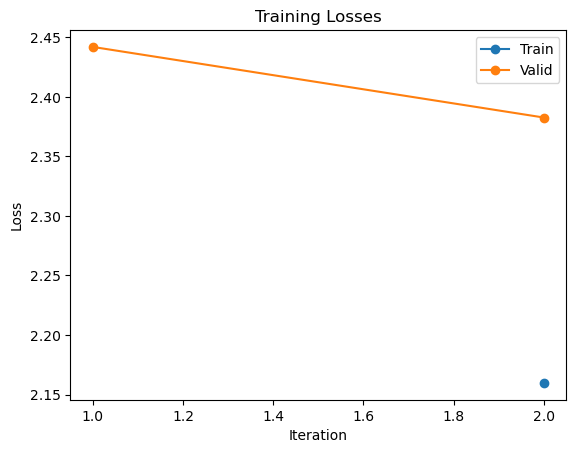

In [19]:
# Prepare model for LoRA training
model.freeze()  # Freeze base model
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

# Check trainable parameters
num_train_params = sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
print(f"Number of trainable parameters: {num_train_params}")

# Set model to training mode
model.train()

# Set the optimizer
opt = optim.Adam(learning_rate=1e-5)

# Initialize metrics callback
metrics = Metrics()

# Begin fine-tuning
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=dev_set,
    training_callback=metrics
)
print("Fine-tuning complete.")

# Optional: Plot training losses if available
if metrics.train_losses and metrics.val_losses:
    train_its, train_losses = zip(*metrics.train_losses)
    val_its, val_losses = zip(*metrics.val_losses)
    plt.plot(train_its, train_losses, '-o', label="Train")
    plt.plot(val_its, val_losses, '-o', label="Valid")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Losses")
    plt.show()


In [ ]:
prompt = "Analyze VM status report and recommend actions:\nSystem Monitoring Report at 2025-04-06 16:34:00+00:00 across VMs:\n\nVM Lubuntu (Instance: Lubuntu):\n  - CPU Idle: 986.9 seconds\n  - Memory used: 21.8% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 50.6 seconds\n  - Failed services: [\'NetworkManager.service\', \'systemd-journald.service\', \'systemd-logind.service\'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Lubuntu V2 (Instance: Lubuntu V2):\n  - CPU Idle: 975.8 seconds\n  - Memory used: 21.5% of 3.7GB total (Available: 2.9GB)\n  - Disk I/O time: 24.0 seconds\n  - Failed services: [\'systemd-journald.service\', \'systemd-logind.service\', \'NetworkManager.service\'] (Count: 3)\n  Detected anomalies: FAILED_SERVICES\n\nVM Ubuntu (Instance: Ubuntu):\n  - CPU Idle: 917.9 seconds\n  - Memory used: 23.5% of 6.7GB total (Available: 5.1GB)\n  - Disk I/O time: 38.5 seconds\n  - Failed services: [\'NetworkManager.service\', \'nginx.service\', \'systemd-journald.service\', \'...\'] (Count: 4)\n  Detected anomalies: FAILED_SERVICES\n\nBased on the above data, compare the statuses of the VMs and decide the appropriate action for each. Options: NO_ACTION, RESTART_SERVICES, RESTART_VM, MIGRATE_VM, SCALE_UP. Explain your reasoning for each VM.\nOptions: NO_ACTION, RESTART_SERVICES, RESTART_VM, MIGRATE_VM, SCALE_UP."

In [79]:
# Reload the finetuned model (with adapters) using the adapter path.
model_lora, _ = load(model_path, adapter_path="adapters")
model_lora.eval()  # Set to evaluation mode

# Generate output with a prompt using the finetuned model.
generate(model_lora, tokenizer, prompt=prompt, verbose=True)




Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Lubuntu (Instance: Lubuntu)
- The CPU idle time is high, indicating that the VM is not utilizing its resources optimally. However, the memory usage is relatively low, and there is still a significant amount of available memory.
- The Disk I/O time is also high, suggesting that there might be some I/O-intensive processes running on the VM.
- The failed services are common across all VMs, which could be due to a system-wide issue.
- Recommendation: Monitor the system for a few more hours to see if the issue persists. If the issue continues, consider rebooting the VM or investigating the failed services to ensure they are not causing any issues.

,

. Lubuntu V2 (Instance: Lubuntu V2)
- The CPU idle time, memory usage, and Disk I/O time are similar to Lubuntu, indicating that the VMs might have similar resource usage patterns.
- The failed services are also the same, suggesting that the system-wide issue might be affecting both VMs.
- Recommendation: Monitor the system for a few more hour

'Lubuntu (Instance: Lubuntu)\n- The CPU idle time is high, indicating that the VM is not utilizing its resources optimally. However, the memory usage is relatively low, and there is still a significant amount of available memory.\n- The Disk I/O time is also high, suggesting that there might be some I/O-intensive processes running on the VM.\n- The failed services are common across all VMs, which could be due to a system-wide issue.\n- Recommendation: Monitor the system for a few more hours to see if the issue persists. If the issue continues, consider rebooting the VM or investigating the failed services to ensure they are not causing any issues.\n\n,\n\n. Lubuntu V2 (Instance: Lubuntu V2)\n- The CPU idle time, memory usage, and Disk I/O time are similar to Lubuntu, indicating that the VMs might have similar resource usage patterns.\n- The failed services are also the same, suggesting that the system-wide issue might be affecting both VMs.\n- Recommendation: Monitor the system for a f